In [1]:
from matplotlib.pylab import rcParams
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import numpy as np
import glob
from sklearn.cluster import KMeans
import string
import re
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [13]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)
#plt.style.use('fivethirtyeight')

# Functions

In [3]:
#function to extract images stored in a df
def image_extract(x,file_name,n):
    x_sample = x.sample(n)
    img_urls = x_sample['image_url']
    for index, url in enumerate(img_urls):
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s%s.jpg" % (file_name, (index+1))
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name

In [4]:
#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

# Pre-processing data

In [ ]:
path ='nrc' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    frame = pd.read_csv(file_,index_col=None, header=0, sep="\t")
    list_.append(frame)
df = pd.concat(list_)

In [ ]:
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)

df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '')
df['ocr'] = df['ocr'].str.findall('\w{4,}').str.join(' ') #remove words shorter than 4 characters
df['ocr'] = df['ocr'].apply(lambda S:S.strip('Advertentie ')) #remove initial Advertentie
df['ocr'] = df['ocr'].str.strip()
df['ocr'] = [' '.join(filter(None,filter(lambda word: word not in stoplist, line))) for line in df['ocr'].str.lower().str.split(' ')]

#setting datete column as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'], drop=False)

#remove colophon
to_drop = ['nrc handelsblad rotterdam westblaak', 'redactie parkstraat hoofdredacteur']
df = df[~df['ocr'].isin(to_drop)]

#remove error
df = df[~df['ocr'].str.contains("jboss")]
df = df[~df['date'].str.contains('date')]
df = df[~df['ocr'].astype(str).str.contains('objecttype')]

#calculating proportion of characters relative to size of the advertisement. 
df['string_length'] = df['ocr'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']

#only select 1948 - 1995
df = df['1948':'1995']

## Store in Pickle

In [5]:
#df.to_pickle("nrc-1948-1994_clean.pkl")
df = pd.read_pickle("nrc-1948-1994_clean.pkl")

The filtering comprised two steps. 
* First, we removed images with a width or height smaller than 500px and advertisements with dimensions that resembled classifieds. 
* Second, we removed image with a character proportion higher than 0.0005, which are advertisements that contained mostly text. 
* Third, we removed 5,820 images that had copyright restrictions. 

This resulted in a dataset of 426,777 advertisements for the period 1945 - 1994.

In [6]:
#maybe filter these out??
full_page_ads = (df['area'] > 80000000)
#rest category wide ads tussen 2500 and 4250 

#rest category wide ads tussen 2500 and 4250 
classifieds = (df['h'] > 5000) & (df['w'] < 900) # tot 650 puur classifieds groter ook filmladders enzo twee groepen
small_ads = (df['h'] < 500) | (df['w'] < 500) #small ads

In [7]:
df = df[(~classifieds) & (~small_ads) & (~full_page_ads)] #dataframe without classifieds and small_ads (n = 486,294)
df = df[(df['character_proportion'] < 0.0005)] #dataframe based on the clustering threshold (n = 207,780)

In [74]:
df_clustering = df[['w','character_proportion']]

## Average Number of Ads per Day

In [8]:
df['freq'] = (df['ocr_clean'].groupby(pd.TimeGrouper('D')).count())
df = df[df.freq!=0]
df = df.sort_values('date')
df['date_f'] = pd.factorize(df['date'])[0] + 1
mapping = dict(zip(df['date_f'], df['date'].dt.date))

In [9]:
df_week = df.resample('W', how='mean')
df_week = df_week.dropna(axis = 0)

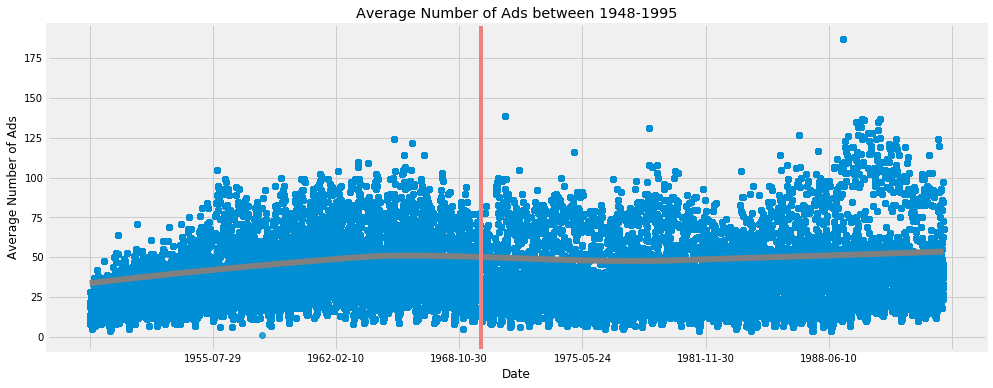

In [24]:
ax = sns.regplot(x="date_f", y="freq", data=df, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
ax.set_xticklabels(labels)
plt.xlabel("Date")
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Number of Ads between 1948-1995")
plt.ylabel("Average Number of Ads")
plt.savefig("Average_Number_of Ads_per_Week.png")
plt.show();

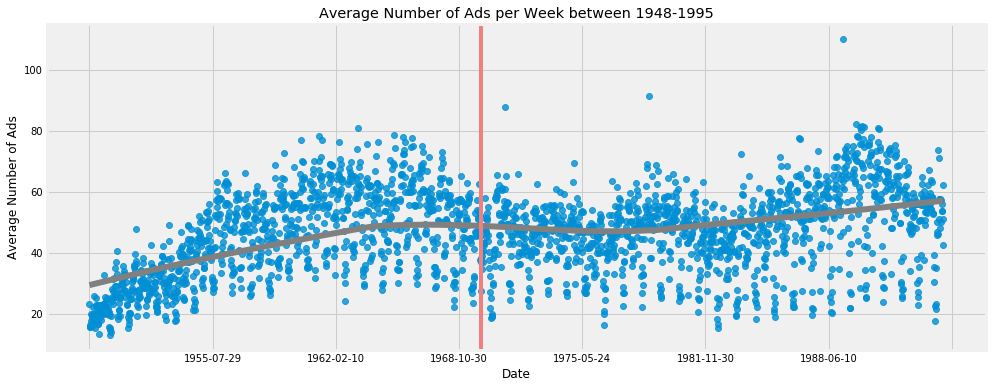

In [14]:
ax = sns.regplot(x="date_f", y="freq", data=df_week, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
ax.set_xticklabels(labels)
plt.xlabel("Date")
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Number of Ads per Week between 1948-1995")
plt.ylabel("Average Number of Ads")
plt.savefig("Average_Number_of Ads_per_Week.png")
plt.show();

## Average Number of Pages

In [11]:
#remove days without newspapers TO DO
pages_per_day = (df['n_pages'].groupby(pd.TimeGrouper('D')).mean()).dropna()

In [12]:
df_day = df.resample('D', how='mean')
df_day = df_day.dropna(axis=0)

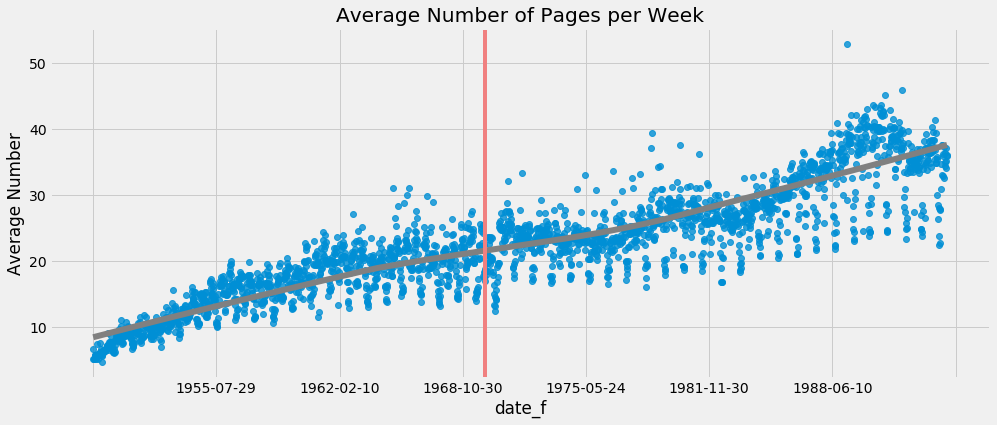

In [13]:
ax = sns.regplot(x="date_f", y="n_pages", data=df_week, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
ax.set_xticklabels(labels)
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Number of Pages per Week")
plt.ylabel("Average Number")

plt.show();

## Ads Per Page

In [17]:
df_week['ads_per_page'] = df_week['freq'] / df_week['n_pages']
#rel_ads_per_day = ads_per_day / pages_per_day

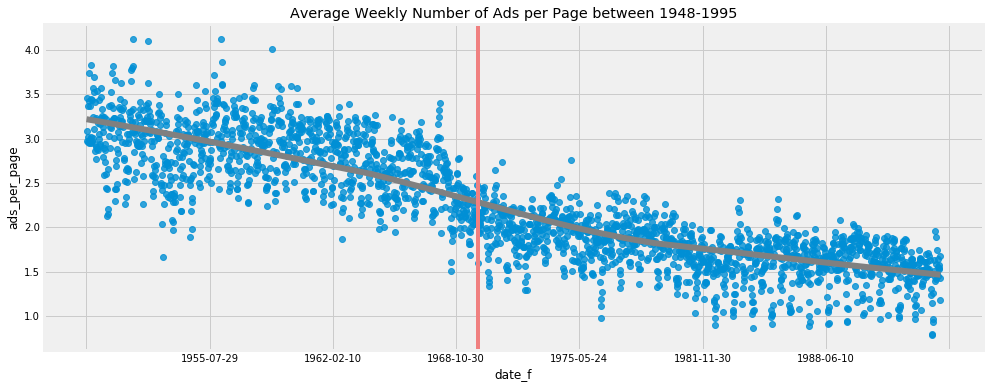

In [23]:
ax = sns.regplot(x="date_f", y="ads_per_page", data=df_week, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
plt.axvline(x=6354.809160, color='lightcoral')
ax.set_xticklabels(labels)
plt.title("Average Weekly Number of Ads per Page between 1948-1995")
plt.savefig("ads_per_page.png")
plt.show();

## Average Size of Ads

In [20]:
df_week['size_per_page'] = df_week['area'] / df_week['n_pages']

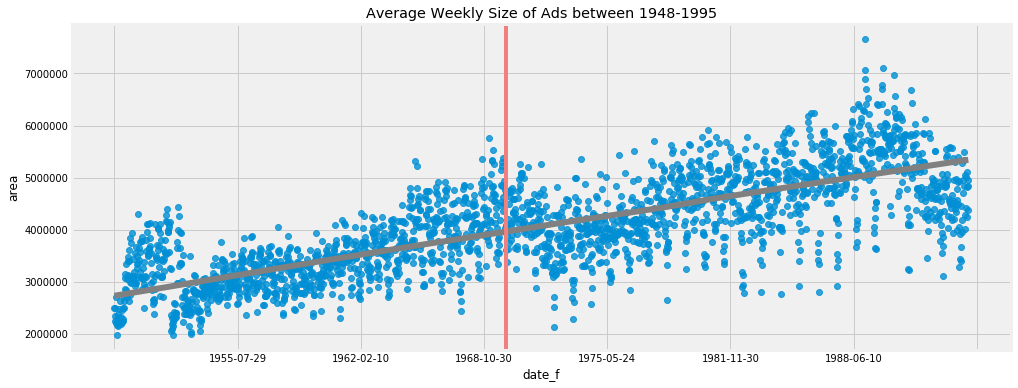

In [21]:
ax = sns.regplot(x="date_f", y="area", data=df_week, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Weekly Size of Ads between 1948-1995")
ax.set_xticklabels(labels)
plt.savefig("size_per_week.png")
plt.show();


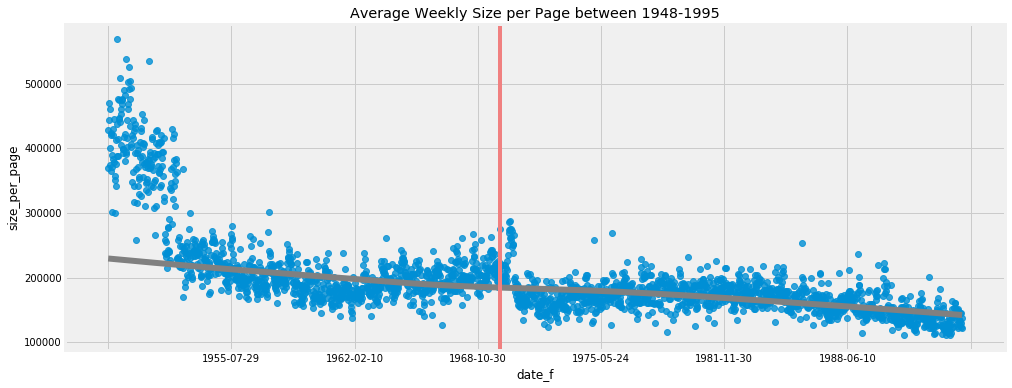

In [22]:
ax = sns.regplot(x="date_f", y="size_per_page", data=df_week, lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Weekly Size per Page between 1948-1995")
ax.set_xticklabels(labels)
plt.savefig("size_per_page.png")
plt.show();


## Average Position per Month

In [19]:
df['position'] = (df['page'] -1) / (df['n_pages'] -1)
df_week['position'] = (df['position'].groupby(pd.TimeGrouper('W')).mean()).dropna()

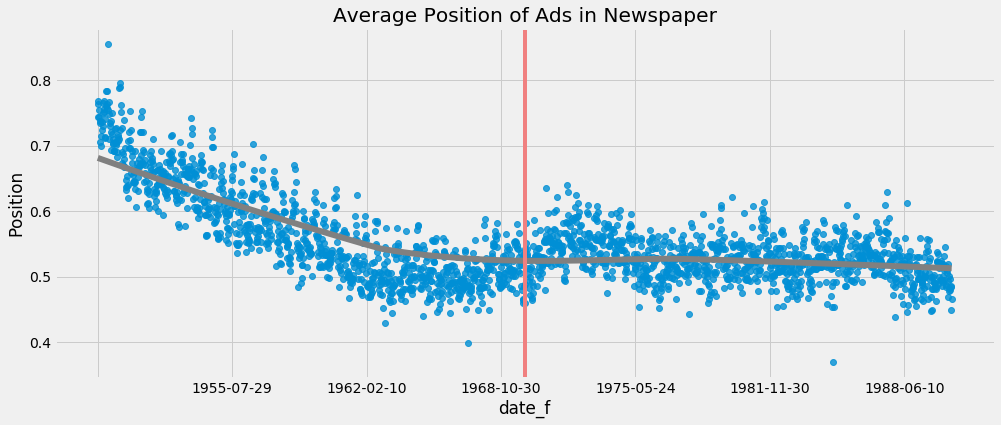

In [73]:
ax = sns.regplot(x="date_f", y="position", data=df_week['1945':'1990'], lowess=True, line_kws={'color': 'grey'})
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
plt.axvline(x=6354.809160, color='lightcoral')
plt.title("Average Position of Ads in Newspaper")
plt.ylabel("Position")
ax.set_xticklabels(labels)
plt.show();
plt.savefig("fig5.png", bbox_inches = 'tight')

## Character Proportion

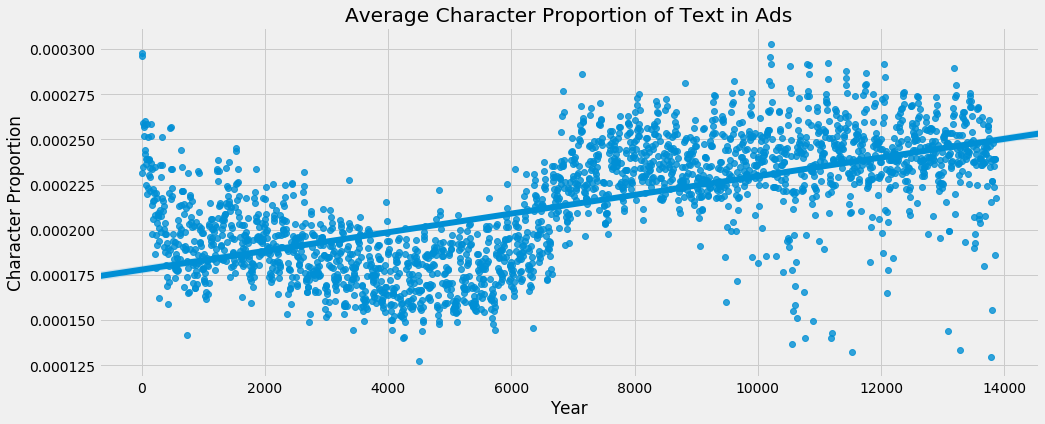

In [27]:
ax = sns.regplot(x="date_f", y="character_proportion", data=df_week)
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
#fig = plt.plot(df['character_proportion'].groupby(pd.TimeGrouper('12M')).aggregate(np.mean).dropna())
plt.xlabel("Year")
plt.title("Average Character Proportion of Text in Ads")
plt.ylabel("Character Proportion")
plt.savefig("fig7.png", bbox_inches = 'tight')

## Text Analysis

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', lowercase=True, max_df = 0.25, min_df = 0.005)
tfidf_matrix =  vectorizer.fit_transform(df['ocr']['1948':'1995'])
scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
feature_list = []
for item in sorted_scores:
    feature_list.append("{0:50} Score: {1}".format(item[0], item[1]))
len(feature_list)
features = pd.DataFrame(feature_list)
features.to_csv("features-cluster2-1970-1994.csv")

In [ ]:
def rel_graph(keyword,time):
    a = df['ocr'][df['ocr'].str.contains(keyword, regex=True)].groupby(pd.TimeGrouper('D')).count()
    b = df['ocr'].groupby(pd.TimeGrouper('D')).count()
    c = a.divide(b)
    c.groupby(pd.TimeGrouper(time)).agg(np.sum).plot()
    
def abs_graph(keyword,time):
    df['ocr'][df['ocr'].str.contains(keyword, regex=True)].groupby(pd.TimeGrouper(time)).count().plot()

In [ ]:
rel_graph('mees', '12M')
rel_graph('europes*', '12M')
rel_graph('nederland', '12M')

In [ ]:
stores = [r'gruyter',
          r'albert heijn',
          r'bijenkorf',
          r'peek',
          r'cloppenburg',
          r'hema',
          r'vroom',
          r'dreesmann'         
         ]


america = [r'ameri[ck]a*',
           r'verenigde staten',
           r'U.S.A.',
           r'USA',
           r'new york',
           r'los angeles',
           r'san francisco'
            ]

auto = [r'automobiel',
        r'automobielen',
        r'fiat',
        r'renault',
        r'ford',
        r'dealer*',
        r'auto ',
        r'citroen',
        r'daf',
        r'volvo',
        r'opel',
        r'personenauto',
        r'autobedrijf',
        r'automobielbedrijf',
        r'chrysler',
        r'mercedes',
        r'bmw',
        r'peugeot',
        r'sedan',
        r'volkswagen',
        r'toyota',
        r'kadett',
        r'escort',
        r'alfa romeo',
        r'mazda',
        r'honda',
        r'corsa',
        r'hatchback',
        r'corolla',
        r'vectra',
        r'saab',
        r'autodealers',
        r'stationwagon',
        r'personenwagen*'
       ]

electronica = [r'philips',
               r'radio',
               r'toestel',
               r'televisie',
               r'philishave',
               r'computer',
               r'computers',
               r'siemens',
               r'bosch',
               r'computers',
               r'cassette*',
               r'braun',
               r'stereo',
               r'wasautomaat',
               r'koelkast',
               r'portable',
               r'ibm',
               r'software',
               r'hifi'
               r'hi-fi',
               r'compact disc*',
               r'telecommunicatie',
               r'canon',
               r'cannon',
               r'personal computer',
               r'processor',
               r'apple',
               r'printer',
               r'printers',
               r'unix',
               r'afstandsbediening',
               r'intel',
               r'hewlett',
               r'packard',
               r'beeldscherm',
               r'toetsenbord',
               r'database',
               r'computersystemen',
               r'scherm',
               r'informatiesystemen',
               r'elektronica',
               r'fax',
               r'faxen',
               r'randapparatuur',
               r'besturingssysteem'    
           ]

cosmetica = [r'prodent',
            r'fama',
            r'kinderzeep',
            r'zeep',
            r'medinos',
            r'organon',
            r'palmolive',
            r'pastilles',
            r'radion',
             r'stophoest',
             r'tandpasta',
             r'teddy',
             r'vitamine*'
             r'wasmiddel'
             r'wrigley',
             r'zwitsal',
             r'sunil',
             r'creme',
             r'omo',
             r'wasmiddel*',
             r'badedas',
             r'tissue',
             r'toiletpapier',
             r'shampoo'        
            ]

smoke =[r'boston',
             r'chief whip',
             r'cigarette*',
             r'golden fiction',
             r'lexington',
             r'old mac',
             r'hunter',
             r'kent',
             r'roxy',
             r'sigaret*',
             r'sketch',
             r'tobaccos',
             r'tabak',
             r'tabakken',
             r'triumph',
             r'turmac',
             r'virginia',
             r'filter*',
             r'sigaar',
             r'sigaren',
             r'camel',
             r'morris',
             r'laurens',
             r'caballero',
             r'senoritas',
             r'pijptabak',
        r'chesterfield',
        r'king size',
        r'filtersigaret*',
        r'british american',
        r'british-american',
        r'batco',
        r'shag'
        ]
        
        
             
travel = [r'reisbureau',
             r'vlucht',
             r'vluchten',
             r'bestemming*',
             r'klm',
          r'airway*'
          r'lufthansa',
          r'airlines',
          r'luchtvaartmaatschappij'       
             ]
             
finance = [r'middenstandsbank',
          r'verzekering',
           r'abn'
           r'amro',
           r'hypotheek',
           r'hypotheekbank',
           r'hypotheken',
           r'verzekeringen',
           r'postspaarbank',
           r'levensverzekering',
           r'rijkspostspaarbank',
           r'spaarrekening',
           r'assurantiën',
           r'rekening',
           r'spaardeposito',
           r'spaarvormen',
           r'financiering',
           r'boerenleenbank',
           r'assurantie',
           r'krediet',
           r'rabobank',
           r'effectenbank',
           r'postgiro',
           r'friesch-gronigsche',
           r'verzekering',
           r'privérekening',
           r'levensverzekering',
           r'spaargeld',
           r'postbank',
           r'verzekeringsmaatschappijen',
           r'investering*',
           r'assurantie'
          ]             
             

koffie = [r'koffie',
          r'douwe egbert*',
          r'moccona',
          r'roodmerk',
          r'nescafe',
          r'koffiebonen',
          r'perla',
          r'snelfilter*'
         ]

In [ ]:
pd.Series((df['ocr'].str.contains(r) for r in auto), auto, name='abs_count')

In [ ]:
pattern = '|'.join(finance)

In [ ]:
a = df['1979':'1980']['ocr'].str.contains(pattern, regex=True).groupby(pd.TimeGrouper('D')).sum().dropna()
b = df['1979':'1980']['ocr'].groupby(pd.TimeGrouper('D')).count()
c = a.divide(b)
c.groupby(pd.TimeGrouper('M')).agg(np.sum).plot()
    

In [ ]:
abs_counts.sort_values(axis=0, ascending=False)

In [ ]:
df3['id'].loc[df3['ocr'].str.contains("computer", regex=True)]

In [ ]:
america = df['ocr'].str.contains("ameri[ck]a*", regex=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice

In [ ]:
cvec = CountVectorizer(min_df=0.001, max_df=.5, ngram_range=(1,2))
cvec.fit(df['1975':'1984']['ocr'])
list(islice(cvec.vocabulary_.items(), 20))
len(cvec.vocabulary_)

In [ ]:
cvec_counts = cvec.transform(df['1975':'1984']['ocr'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

In [ ]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

## Word2vec

In [ ]:
from gensim import corpora, models, similarities
import nltk

In [ ]:
docs = df['1970':'1980']["ocr"].apply(nltk.word_tokenize)

In [ ]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=0.95, no_above=0.05)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
lda = models.LdaModel(corpus, num_topics=20, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)

In [ ]:
lda.show_topics()